# **Automated 3D EEG Electrode Localization Pipeline**

This notebook presents an end-to-end computational pipeline designed to automate the localization and labeling of EEG electrodes from 3D surface scans. By leveraging geometric feature extraction and density-based clustering, the system transforms raw mesh data into standardized anatomical coordinates.

## Project Overview

Accurate electrode positioning is critical for source localization and reproducible EEG research. Traditionally, this process involves manual digitization, which is time-consuming and prone to inter-operator variability. This tool provides an automated digital pipeline that is both precise and scalable, achieving high spatial accuracy in electrode localization.

Notably, the methodologies implemented here align with established academic standards in the field, such as those discussed by Robert Oostenveld and colleagues (e.g., Giari et al., 2019, Journal of Neuroscience Methods), providing a robust validation for the pipeline's computational framework.

## Key Methodologies

**Coordinate Alignment:** Rigid-body transformation of the raw scan into the RAS (Right-Anterior-Superior) coordinate system using anatomical fiducials (Nz, LPA, RPA).

**Geometric Feature Extraction:** Application of Gaussian Curvature analysis to identify local convexities corresponding to electrode sockets.

**Density-Based Clustering:** Utilization of the DBSCAN algorithm to robustly isolate electrode sites from surface noise without prior knowledge of the channel count.

**Spatial Warping:** Implementing Affine Transformations and Least Squares estimation to map detected centroids to the standard 10-20 system template.

## Usage

**Input:** 3D Mesh file (e.g., .obj, .stl).

**Interaction:** User-guided selection of 5 reference points (Nz, LPA, RPA, Cz, Oz).

**Output:** Labeled electrode coordinates exported in a standard .txt format.

## Step 1: Initialization and Reference Data Setup

In this initial step, we import the necessary libraries for 3D mesh processing, spatial clustering, and mathematical computations.

We also define the **Electrode Template (masterdict)**. This dictionary contains the standardized coordinates for a 32-channel EEG layout in a generic space. These coordinates serve as our "Gold Standard" for the 10-20 system and will later be warped to fit the specific geometry of the subject's scanned head.

**Key Libraries Used:**
* `PyVista`: For 3D mesh visualization and geometric operations.
* `NumPy`: For high-performance linear algebra and coordinate transformations.
* `Scikit-learn (DBSCAN)`: For density-based spatial clustering of electrode sites.
* `SciPy`: For calculating Euclidean distances during electrode labeling.

In [1]:
# Imports
import numpy as np
import pyvista as pv
from sklearn.cluster import DBSCAN
from scipy.spatial import distance


# Standard 10-20 electrode coordinates. Currently using only 32 electrode layout.
masterdict = {
    "LPA": [-86.0761, -19.9897, -47.9860],    "RPA": [85.7939, -20.0093, -48.0310],    "Nz": [0.0083, 86.8110, -39.9830],
    "Fp1": [-29.4367, 83.9171, -6.9900],    "Fp2": [29.8723, 84.8959, -7.0800],    "F7": [-70.2629, 42.4743, -11.4200],
    "F3": [-50.2438, 53.1112, 42.1920],    "Fz": [0.3122, 58.5120, 66.4620],    "F4": [51.8362, 54.3048, 40.8140],
    "F8": [73.0431, 44.4217, -12.0000],    "FT7": [-80.7750, 14.1203, -11.1350],    "FC3": [-60.1819, 22.7162, 55.5440],
    "FCz": [0.3761, 27.3900, 88.6680],    "FC4": [62.2931, 23.7228, 55.6300],    "FT8": [81.8151, 15.4167, -11.3300],
    "C3": [-65.3581, -11.6317, 64.3580],    "Cz": [0.4009, -9.1670, 100.2440],    "C4": [67.1179, -10.9003, 63.5800],
    "TP7": [-84.8302, -46.0217, -7.0560],    "CP3": [-63.5562, -47.0088, 65.6240],    "CPz": [0.3858, -47.3180, 99.4320],
    "CP4": [66.6118, -46.6372, 65.5800],    "TP8": [85.5488, -45.5453, -7.1300],    "P3": [-53.0073, -78.7878, 55.9400],
    "Pz": [0.3247, -81.1150, 82.6150],    "P4": [55.6667, -78.5602, 56.5610],    "O1": [-29.4134, -112.4490, 8.8390],
    "Oz": [0.1076, -114.8920, 14.6570],    "O2": [29.8426, -112.1560, 8.8000],    "T3": [-84.1611, -16.0187, -9.3460],
    "T5": [-72.4343, -73.4527, -2.4870],    "T4": [85.0799, -15.0203, -9.4900],    "T6": [73.0557, -73.0683, -2.5400],
}

## Step 2: Interactive Point Selection & Manual Override

Ideally, the anatomical landmarks (Fiducials) are selected interactively using a 3D plotter. However, due to Jupyter Notebook's limitations with interactive 3D backends, I provide a manual override option below.

**Workflow:**
1. The commented-out code block contains the full interactive selection logic (for use in local Python environments).
2. For this notebook execution, we manually assign the coordinates extracted from a previous successful run to ensure the pipeline continues seamlessly.

*Note: In a clinical or research production environment, these coordinates would be generated by the interactive picker.*

In [2]:
# First we select the fiducial and reference points to align our mesh and electrode positions.
mesh = pv.read('data/NuhAbiEEG_Elektrotsuz1_mesh.obj')
pv.set_jupyter_backend('static')

# --- OPTION 1: INTERACTIVE SELECTION (Commented out for Notebook stability) ---
""""
# This is where our reference points will be stored
mesh_elec = {}
# Order of selection
labels_to_pick = ['Nz', 'LPA', 'RPA', 'Cz', 'Oz']
current_pick_index = 0

p = pv.Plotter()
p.add_mesh(mesh, color='antiquewhite')


def callback(point):
    global current_pick_index

    if current_pick_index < len(labels_to_pick):
        label = labels_to_pick[current_pick_index]
        mesh_elec[label] = np.array(point)

        # Visual feedback: Place a sphere and a label showing what is selected and where.
        p.add_mesh(pv.Sphere(radius=3, center=point), color='red')
        p.add_point_labels([point], [label], font_size=15, point_color='red')

        print(f"{label} is saved: {point}")
        current_pick_index += 1

        if current_pick_index == len(labels_to_pick):
            print("\nAll reference points have been selected, you can close this window.")
    else:
        print("All of the refence points have already been selected.")


p.enable_surface_point_picking(callback=callback, show_message=True)
print(f"Please select in given order: {labels_to_pick}")
p.show()

# Automatically assign the selected locations for downstream processing
try:
    nz_coord = mesh_elec['Nz']
    lpa_coord = mesh_elec['LPA']
    rpa_coord = mesh_elec['RPA']
    cz_coord = mesh_elec['Cz']
    oz_coord = mesh_elec['Oz']
except KeyError:
    print("ERROR: Not all points were selected. Please re-run this cell and pick all 5 points.")
"""

# --- OPTION 2: MANUAL OVERRIDE (For Notebook Execution) ---
# Replace these values with the coordinates you obtained from your local run
mesh_elec = {
    'Nz':  np.array([-10.31877492, 136.77468663, 400.73310825]),  # Örnek değerler, kendi koordinatlarını yaz
    'LPA': np.array([ 71.61765877, 158.3323447,  299.1906164 ]),
    'RPA': np.array([-84.1060873,  165.13653218, 299.34759749]),
    'Cz':  np.array([-3.15114407, 282.98993302, 358.80812046]),
    'Oz':  np.array([-12.35072227, 255.54254653, 230.85776391])
}

# Assign coordinates for downstream processing
nz_coord = mesh_elec['Nz']
lpa_coord = mesh_elec['LPA']
rpa_coord = mesh_elec['RPA']
cz_coord = mesh_elec['Cz']
oz_coord = mesh_elec['Oz']

print("Fiducial coordinates successfully loaded via manual override.")

Fiducial coordinates successfully loaded via manual override.


## Step 3: Anatomical Alignment and RAS Transformation

The raw 3D mesh is initially in an arbitrary coordinate space determined by the scanner's position. To perform meaningful EEG localization, we must transform the mesh into the **RAS (Right-Anterior-Superior)** coordinate system.

### The Mathematical Logic
In this step, we construct a custom **4x4 Transformation Matrix** based on the selected fiducial points:

1. **Origin:** Defined as the exact midpoint between the Left and Right Pre-Auricular points (**LPA & RPA**).
2. **X-axis (Right):** A vector pointing from LPA towards RPA.
3. **Z-axis (Superior):** Derived using the **Cross Product** of the X-axis and a temporary vector pointing toward the Nasion (**Nz**). This ensures the Z-axis is perfectly perpendicular to the axial plane.
4. **Y-axis (Anterior):** Re-calculated as the cross product of the Z and X axes to ensure a perfectly **orthogonal** coordinate system.



### Rigid-Body Transformation
We apply a **Rigid-Body Transformation**, which means we only rotate and translate the mesh without changing its size or shape. This preserves the anatomical integrity of the subject's head.

**Functions defined in this cell:**
* `align_mesh()`: Calculates the rotation and translation required to center the head and align it with the cardinal axes.
* `transform_points()`: Applies the calculated transformation matrix to individual coordinate points using **Homogeneous Coordinates**.

*Note: After this transformation, the head will be centered at (0,0,0), looking towards the positive Y-axis, with the top of the head facing the positive Z-axis.*

/Users/deniztuncertepe/PycharmProjects/denemedeneme/.venv/lib/python3.13/site-packages/pyvista/core/filters/data_object.py:180: PyVistaDeprecationWarning: The default value of `inplace` for the filter `PolyData.transform` will change in the future. Previously it defaulted to `True`, but will change to `False`. Explicitly set `inplace` to `True` or `False` to silence this warning.
  warnings.warn(msg, PyVistaDeprecationWarning)


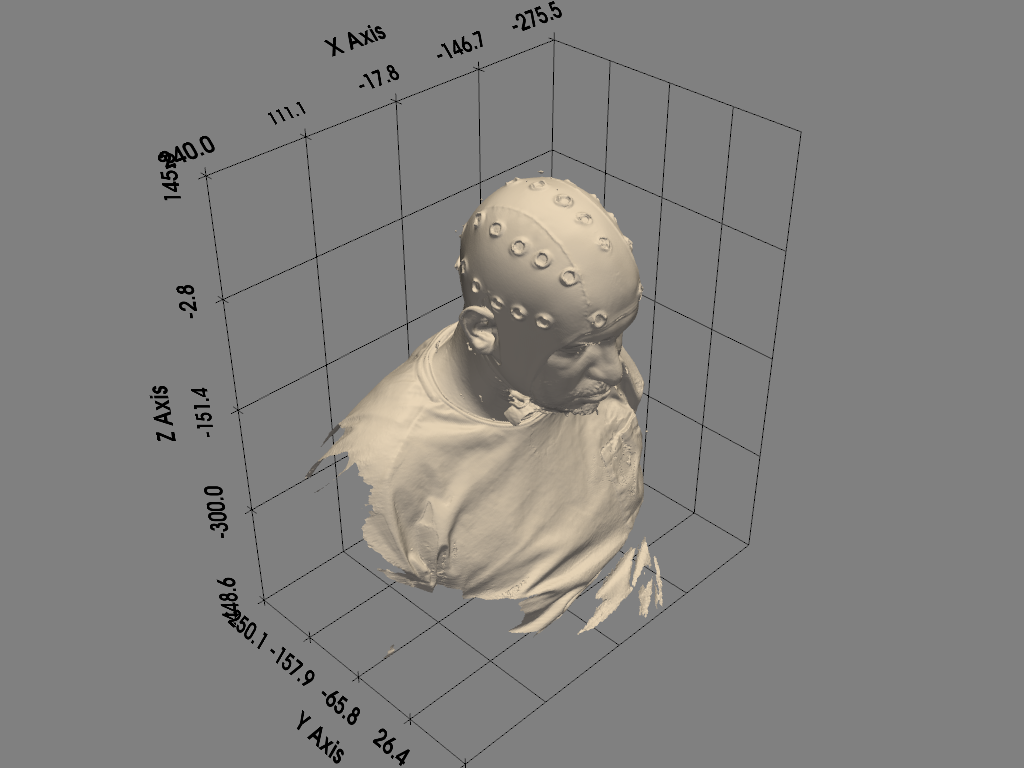

In [3]:
# Here we define a new function to align our imported mesh
def align_mesh(mesh, nz, lpa, rpa):
    # Origin is in the exactly middle of LPA and RPA, as determined by globally accepted standarts.
    origin = (np.array(lpa) + np.array(rpa)) / 2.0

    # X axis goes through RPA and LPA
    x_axis = np.array(rpa) - np.array(lpa)
    x_axis /= np.linalg.norm(x_axis)

    # A vector directed towards Nasion point from the origin. This is our temporary y axis.
    y_temp = np.array(nz) - origin
    y_temp /= np.linalg.norm(y_temp)

    # Finding the z axis
    z_axis = np.cross(x_axis, y_temp)
    z_axis /= np.linalg.norm(z_axis)

    # Finding the actual y axis
    y_axis = np.cross(z_axis, x_axis)

    # Creating a rotation matrix using our newly determined axises
    R = np.vstack([x_axis, y_axis, z_axis])
    # 4x4 Transformation matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = -R @ origin

    aligned_mesh = mesh.copy()
    aligned_mesh.transform(T)
    return aligned_mesh, T


# We align our mesh with the defined function
aligned_mesh, transform_matrix = align_mesh(mesh, nz_coord, lpa_coord, rpa_coord)


def transform_points(points, T):
    # Converting (N, 3) points to (N, 4) homogeneous coordinates
    points_homogenous = np.column_stack([points, np.ones(len(points))])

    # Multiplying the points with the transformation matrix (T @ P.T).T
    transformed_points_homogenous = (T @ points_homogenous.T).T

    # Returning back to (N, 3) format
    return transformed_points_homogenous[:, :3]


# Converting our point to an array format
original_points = np.array([nz_coord, lpa_coord, rpa_coord, cz_coord, oz_coord])

# Calculating our new coordinates
new_coords = transform_points(original_points, transform_matrix)
R_labels = ["Nz", "LPA", "RPA", "Cz", "Oz"]

# Creating a dictionary of reference points
new_coords_dict = dict(zip(R_labels, new_coords))

p = pv.Plotter()
p.add_mesh(aligned_mesh, color='antiquewhite')
p.background_color = 'grey'
p.show_grid()
p.show()

## Step 4: Surface Feature Extraction and Spatial Filtering

In this step, we isolate the electrode sites from the rest of the scalp by analyzing the surface geometry and applying spatial constraints.

### Gaussian Curvature Analysis
Electrodes are typically housed in sockets or plastic mounts that create distinct "bumps" or "pits" on the scanned surface. We use **Gaussian Curvature** to identify these regions.
* Smooth areas of the scalp have near-zero curvature.
* Electrode sockets exhibit high positive or negative curvature values, allowing us to distinguish them mathematically from the surrounding skin.



### Spatial Clipping and Noise Reduction
To optimize processing and remove unwanted artifacts (like neck, shoulders, or scan noise far from the head), we apply two types of clipping:
1. **Z-axis (Superior) Clip:** We remove data below a certain height (e.g., 25mm above the origin) to focus strictly on the EEG cap area.
2. **X-axis (Lateral) Clip:** Based on the **Inter-Aural Distance** (LPA to RPA), we define a width limit. This ensures we don't pick up noise from the ears or the scanner's background.

### Candidate Masking
Finally, we apply a boolean mask that combines our curvature threshold (`> 0.05`) and spatial limits. This extracts a set of **"Electrode Candidates"**—points that are geographically in the right place and possess the right surface characteristics.

*The resulting "Gold" points in the visualization represent the potential electrode sites that will be fed into the clustering algorithm.*

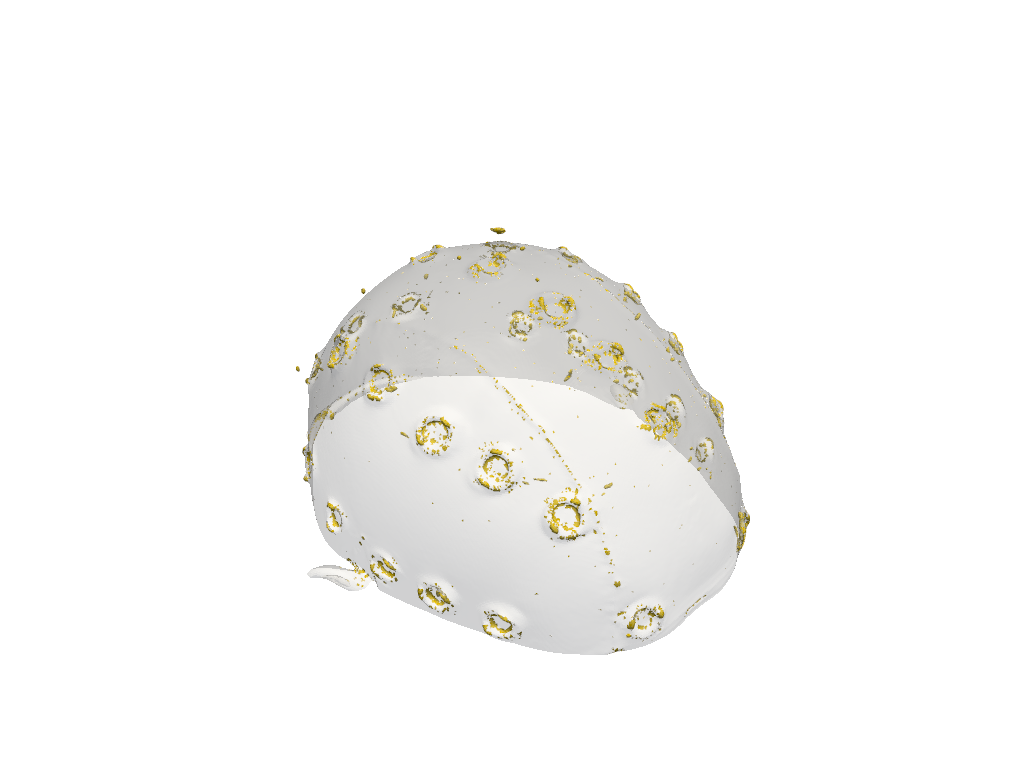

In [4]:
# Calculating the Gaussian Curvature value of every point on the aligned mesh, electrode sockets have much higher values than the usually-smooth scalp.
aligned_mesh["curv_data"] = aligned_mesh.curvature(curv_type='gaussian')

# We clip below the EEG cap of the mesh, aim here is to reduce unwanted noise.
# WARNING: The Z-coordinate in 'origin' (0, 0, 25) must be tuned manually for each specific scan to avoid clipping actual electrodes.
cap_mesh = aligned_mesh.clip(normal='z', origin=(0, 0, 25), invert=False)

# We apply a lateral (X-axis) clip based on the inter-aural distance (LPA to RPA).
# This ensures that we only process data within the head's width, effectively removing artifacts or scan noise outside the ears.
dist_x = np.linalg.norm(np.array(rpa_coord) - np.array(lpa_coord))
x_limit = (dist_x / 2.0) + 12.5  # Adding a 12.5mm tolerance to prevent clipping edge electrodes

# Applying a mask to eliminate noise
mask = (cap_mesh["curv_data"] > 0.05) & \
       (cap_mesh.points[:, 0] > -x_limit) & \
       (cap_mesh.points[:, 0] < x_limit)

# Determining potential electrode points.
electrode_candidates = cap_mesh.extract_points(mask)

# This is the potential electrode points:
p = pv.Plotter()
p.add_mesh(cap_mesh, color="white", opacity=0.3)
p.add_mesh(electrode_candidates, color="gold")
p.show()

## Step 5: Unsupervised Clustering with DBSCAN

At this stage, we have a cloud of candidate points that likely belong to electrodes. However, these are just individual points without any grouping. We use the **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** algorithm to organize these points into distinct electrode sites.

### Why DBSCAN?
Unlike K-Means, DBSCAN does not require us to specify the number of clusters (electrodes) beforehand. This is crucial because:
* It can automatically identify an arbitrary number of electrodes based on the scan quality.
* It is robust to **noise**; points that do not belong to a dense cluster are labeled as `-1` and discarded.



### Parameters and Centroid Calculation
* **`eps` (Epsilon):** The maximum distance between two samples for one to be considered as in the neighborhood of the other.
* **`min_samples`:** The number of samples in a neighborhood for a point to be considered as a core point.
* **Centroid Extraction:** Once clusters are identified, we calculate the **mean spatial coordinate (centroid)** for each cluster. This effectively reduces a cluster of hundreds of points into a single, precise `(x, y, z)` coordinate representing the center of an electrode.

*The output of this step is a list of coordinates (`electrode_centers`), each representing a detected electrode on the 3D model.*

In [5]:
points = electrode_candidates.points

# Clustering electrode sites using DBSCAN (Density-Based Spatial Clustering of Applications with Noise).
# This allows the identification of an arbitrary number of electrodes without prior knowledge.
# NOTE: 'eps' (search radius) and 'min_samples' (density threshold) are sensitive to mesh resolution.
db = DBSCAN(eps=5, min_samples=80).fit(points)
cluster_labels = db.labels_  # Extracting cluster labels for each point

# Identifying unique cluster labels to iterate through each detected electrode.
# 'set(labels)' removes duplicates, giving us a list of distinct cluster IDs.
unique_labels = set(cluster_labels)
centers = []

electrode_centers = []

for label in unique_labels:
    if label == -1: continue # -1 means noise, skip

    # We check every point and detect each cluster's center to refer it as an 'electrode'
    class_member_mask = (cluster_labels == label)
    cluster_points = points[class_member_mask]
    centers.append(cluster_points.mean(axis=0))

electrode_centers = np.array(centers)

## Step 6: Spatial Warping and Template Adaptation

Now that we have detected electrode centers on the subject's mesh, we need a way to label them according to the **Standard 10-20 System**. However, the standard template and the subject's scan have different dimensions. We solve this using **Affine Transformation**.

### he Least Squares Approach
To map the generic template onto our specific model, we utilize five anatomical anchors (**LPA, RPA, Nz, Cz, Oz**). The algorithm calculates a **4x3 Transformation Matrix** using the **Least Squares method**:
* It finds the optimal combination of scaling, rotation, and shearing that minimizes the distance between the template anchors and the subject's actual landmarks.
* This is a "global" adaptation that accounts for differences in head size (e.g., a larger or smaller skull than the template).



### Homogeneous Coordinates
By "padding" our 3D coordinates with an extra dimension (turning $[x, y, z]$ into $[x, y, z, 1]$), we can apply translation and linear transformations simultaneously. This ensures that every electrode in the 10-20 template (`masterdict`) is "warped" into the subject's specific space.

*The result of this step (`final_coords`) is a set of "Expected Positions" for the electrodes, which we will use as a reference for the final labeling.*

In [6]:
# Here we define a function to 'warp' the template electrode positions to our scanned mesh. Using selected reference points.
def warp_electrodes_to_model(template_dict, target_pts):

    # Reference points on the TEMPLATE dictionary
    src_pts = np.array([
        template_dict["LPA"],
        template_dict["RPA"],
        template_dict["Nz"],
        template_dict["Cz"],
        template_dict["Oz"],
    ])

    # Reference points of the mesh
    dst_pts = np.array([
        target_pts["LPA"],
        target_pts["RPA"],
        target_pts["Nz"],
        target_pts["Cz"],
        target_pts["Oz"],
    ])

    # Apply the Affine Transform Matrix (4x3 matrix)
    # Using padded coordinates: [x, y, z, 1]
    def pad(x): return np.hstack([x, np.ones((x.shape[0], 1))])

    # Find the best transform matrix using Least Squares method
    T, residuals, rank, s = np.linalg.lstsq(pad(src_pts), dst_pts, rcond=None)

    # Apply this matrix to all electrode points.
    warped_electrodes = {}
    for label, coords in template_dict.items():
        # Turn the point into a homogenous coordinate [x, y, z, 1]
        c_arr = np.array([coords[0], coords[1], coords[2], 1.0])
        # Calculating the new coordinates
        new_pos = c_arr @ T
        warped_electrodes[label] = new_pos.tolist()

    return warped_electrodes



# Warp the template coordinates to our mesh
final_coords = warp_electrodes_to_model(masterdict, new_coords_dict)

## Step 7: Final Labeling and Nearest Neighbor Matching

In this final computational step, we bridge the gap between the **detected centroids** (unlabeled points from the scan) and the **warped template** (labeled expected positions).

### Euclidean Distance Matching
We iterate through each detected electrode center and compare it against the entire 10-20 template using **Euclidean Distance**. The goal is to find the "Best Match" for each physical point found on the mesh.

### Noise Filtering and Validation
To ensure high data quality, we implement two layers of validation:
1. **Distance Threshold:** A detected point is only labeled if it is within **20mm** of an expected template position. Points further away are categorized as **Noise** (e.g., artifacts like hair clips or skin irregularities).
2. **Conflict Resolution:** If two detected points compete for the same label (e.g., "Cz"), the algorithm dynamically assigns the label to the point with the smallest distance to the theoretical center, ensuring a 1-to-1 mapping.



### Final Visualization
The plotter displays the culmination of the entire pipeline:
* **Green Spheres:** Successfully identified and labeled electrodes.
* **Gray Spheres:** Filtered noise points that did not meet the matching criteria.
* **Labels:** Standard 10-20 nomenclature (Fp1, Cz, Oz, etc.) mapped directly onto the subject's unique 3D geometry.

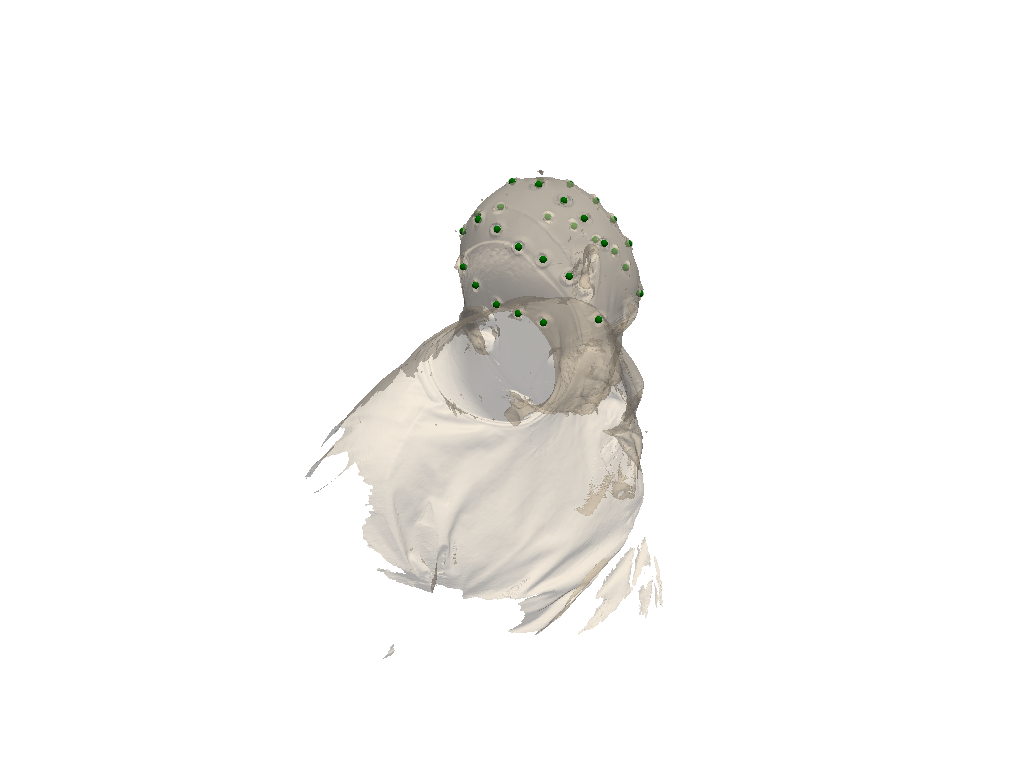

In [7]:
labeled_electrodes = {}
noise_points = []

for found_point in electrode_centers:
    best_match = None
    min_dist = float('inf')

    for name, std_coord in final_coords.items():
        # Calculate the Euclidean distance
        dist = distance.euclidean(found_point, std_coord)

        if dist < min_dist:
            min_dist = dist
            best_match = name

    # Label the electrode if it's eligible
    if min_dist < 20:
        if best_match in labeled_electrodes and distance.euclidean(labeled_electrodes[best_match], final_coords[best_match]) >= min_dist:
            labeled_electrodes[best_match] = found_point
        elif best_match not in labeled_electrodes:
            labeled_electrodes[best_match] = found_point
        else:
            continue
    else:
        noise_points.append(found_point)

p = pv.Plotter()
p.add_mesh(aligned_mesh, color="antiquewhite", opacity=0.5)

# Add the matches with labels
for name, pos in labeled_electrodes.items():
    p.add_mesh(pv.Sphere(radius=4, center=pos), color="green")
    p.add_point_labels([pos], [name], font_size=12, point_color='green')

# Show 'false' electrodes, subtle of course
for pos in noise_points:
    p.add_mesh(pv.Sphere(radius=2, center=pos), color="gray", opacity=0.5)

p.add_text("Final Electrode Mapping (10-20 System)", font_size=12, color='white', position='upper_left')
p.show()

## Step 8: Data Export and Results

The final stage of the pipeline is to export the identified and labeled coordinates into a machine-readable format. This enables the localized positions to be integrated seamlessly into downstream EEG analysis software.

### Output Specification
The resulting file is structured to be compatible with major neuroimaging toolboxes (such as MNE-Python, EEGLAB, or FieldTrip):

* **Format:** Tab-separated `.txt` file (TSV).
* **Contents:** Each row contains the electrode label followed by its precise **X, Y, and Z** coordinates.
* **Precision:** Coordinates are exported with two-decimal precision (in millimeters).

### Next Steps
The generated `electrode_locations.txt` file can now be used for:
1. **Source Localization:** Mapping brain activity to anatomical structures with high spatial precision.
2. **Topographic Mapping:** Creating accurate 2D and 3D head models for sensor-level analysis.
3. **Project Documentation:** Keeping a digital record of the exact electrode placement for each subject.

*The pipeline is now complete. All detected electrode coordinates have been saved to the project directory.*

In [8]:
with open("electrode_locations.txt", "w") as f:
    f.write("label\tx\ty\tz\n") # Title
    for name, pos in labeled_electrodes.items():
        f.write(f"{name}\t{pos[0]:.2f}\t{pos[1]:.2f}\t{pos[2]:.2f}\n")

print("Electrode coordinates are saved as 'electrode_locations.txt'")

Electrode coordinates are saved as 'electrode_locations.txt'


### References & Acknowledgments
* This pipeline was developed independently at the Neurophysiology Laboratory.
* Methodology validation aligns with standard practices in 3D electrode digitizing (e.g., *Giari et al., 2019, Journal of Neuroscience Methods*).
* Coordinate systems follow the **RAS (Right-Anterior-Superior)** convention as used in major neuroimaging standards.

## 🚀 Roadmap & Future Improvements (v2.0)

To further enhance the precision, automation, and compatibility of this pipeline, the following features are planned for future releases:

1. **Optimized Label Assignment:** Implementing the **Hungarian Algorithm** (Linear Sum Assignment) to globally minimize matching errors instead of the current local nearest-neighbor approach.
2. **Refined Alignment Model:** Moving beyond simple warping to a **Rigid Transformation + Optional Isotropic Scaling** model to maintain the geometric proportions of the 10-20 template.
3. **Automated Landmark Detection:** Integrating deep learning or geometry-based heuristics for **Auto-Cz/Oz estimation**, reducing the need for manual point picking.
4. **Enhanced Software Interoperability:** Adding native export support for **FieldTrip (.elec)** and **MNE-Python (.fif)** digitizer formats.
5. **Subject-Specific Modeling:** Integration of the localized coordinates with automated **BEM (Boundary Element Method)** head model generation for high-density source reconstruction.